## References

https://docs.trychroma.com/reference/py-client

https://docs.trychroma.com/guides

## Disk-based vector database 

You can configure Chroma to save and load the database from your local machine. Data will be persisted automatically and loaded on start (if it exists)

Creates a persistent instance of Chroma that saves to disk. This is useful for
    testing and development, but not recommended for production use.

https://github.com/chroma-core/chroma/blob/main/chromadb/__init__.py#L129
```python
def PersistentClient(
    path: str = "./chroma",
    settings: Optional[Settings] = None,
    tenant: str = DEFAULT_TENANT,
    database: str = DEFAULT_DATABASE,
) -> ClientAPI:
    """
    Creates a persistent instance of Chroma that saves to disk. This is useful for
    testing and development, but not recommended for production use.

    Args:
        path: The directory to save Chroma's data to. Defaults to "./chroma".
        tenant: The tenant to use for this client. Defaults to the default tenant.
        database: The database to use for this client. Defaults to the default database.
    """
```

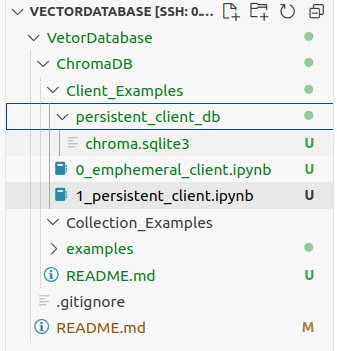

It will generate a folder base on your path

### Create Client

In [1]:
import chromadb
persistent_client = chromadb.PersistentClient(path='./persistent_client_db')

In [2]:
persistent_client.get_settings()

Settings(environment='', chroma_api_impl='chromadb.api.segment.SegmentAPI', chroma_server_nofile=None, chroma_server_thread_pool_size=40, tenant_id='default', topic_namespace='default', chroma_server_host=None, chroma_server_headers=None, chroma_server_http_port=None, chroma_server_ssl_enabled=False, chroma_server_ssl_verify=None, chroma_server_api_default_path='/api/v1', chroma_server_cors_allow_origins=[], is_persistent=True, persist_directory='./persistent_client_db', chroma_memory_limit_bytes=0, chroma_segment_cache_policy=None, allow_reset=False, chroma_auth_token_transport_header=None, chroma_client_auth_provider=None, chroma_client_auth_credentials=None, chroma_server_auth_ignore_paths={'/api/v1': ['GET'], '/api/v1/heartbeat': ['GET'], '/api/v1/version': ['GET']}, chroma_overwrite_singleton_tenant_database_access_from_auth=False, chroma_server_authn_provider=None, chroma_server_authn_credentials=None, chroma_server_authn_credentials_file=None, chroma_server_authz_provider=None, 

In [4]:
persistent_client.count_collections()

0

In [5]:
persistent_client.list_collections()

[]

### Create Collection

https://github.com/chroma-core/chroma/blob/main/chromadb/api/__init__.py#L430
```python
def get_or_create_collection(
        self,
        name: str,
        configuration: Optional[CollectionConfiguration] = None,
        metadata: Optional[CollectionMetadata] = None,
        embedding_function: Optional[
            EmbeddingFunction[Embeddable]
        ] = ef.DefaultEmbeddingFunction(),  # type: ignore
        data_loader: Optional[DataLoader[Loadable]] = None,
    ) -> Collection:
        model = self._server.get_or_create_collection(
            name=name,
            metadata=metadata,
            tenant=self.tenant,
            database=self.database,
            configuration=configuration,
        )
        return Collection(
            client=self._server,
            model=model,
            embedding_function=embedding_function,
            data_loader=data_loader,
        )
```

In [6]:
persistent_collection = persistent_client.get_or_create_collection(name='test_persistent_collection')
persistent_collection

Collection(id=c4f93020-5ebc-4624-bc02-b55d90d53ffe, name=test_persistent_collection)

In [7]:
persistent_client.count_collections()

1

In [8]:
persistent_client.list_collections()

[Collection(id=c4f93020-5ebc-4624-bc02-b55d90d53ffe, name=test_persistent_collection)]

### Add Text Data to Collection

https://github.com/chroma-core/chroma/blob/main/chromadb/api/models/Collection.py
```python
    def add(
        self,
        ids: OneOrMany[ID],
        embeddings: Optional[  # type: ignore[type-arg]
            Union[
                OneOrMany[Embedding],
                OneOrMany[np.ndarray],
            ]
        ] = None,
        metadatas: Optional[OneOrMany[Metadata]] = None,
        documents: Optional[OneOrMany[Document]] = None,
        images: Optional[OneOrMany[Image]] = None,
        uris: Optional[OneOrMany[URI]] = None,
    ) -> None:
        """Add embeddings to the data store.
        Args:
            ids: The ids of the embeddings you wish to add
            embeddings: The embeddings to add. If None, embeddings will be computed based on the documents or images using the embedding_function set for the Collection. Optional.
            metadatas: The metadata to associate with the embeddings. When querying, you can filter on this metadata. Optional.
            documents: The documents to associate with the embeddings. Optional.
            images: The images to associate with the embeddings. Optional.
            uris: The uris of the images to associate with the embeddings. Optional.

        Returns:
            None

        Raises:
            ValueError: If you don't provide either embeddings or documents
            ValueError: If the length of ids, embeddings, metadatas, or documents don't match
            ValueError: If you don't provide an embedding function and don't provide embeddings
            ValueError: If you provide both embeddings and documents
            ValueError: If you provide an id that already exists

        """
```

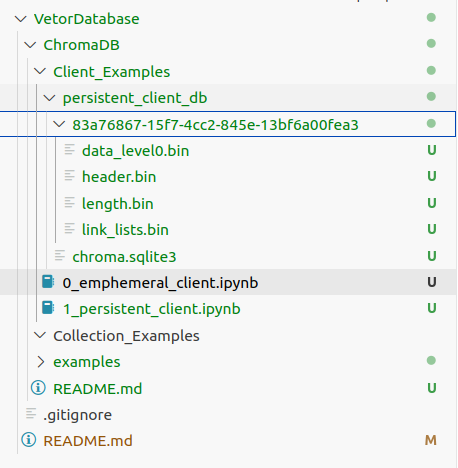

In [9]:
ids = ['id_1', 'id_2', 'id_3']
documents = ['This is document1', 'This is document2', 'This is document3']

persistent_collection.add(
    ids=ids,
    documents=documents 
)

### Query

https://github.com/chroma-core/chroma/blob/main/chromadb/api/models/Collection.py#L141
```python
    def query(
        self,
        query_embeddings: Optional[  # type: ignore[type-arg]
            Union[
                OneOrMany[Embedding],
                OneOrMany[np.ndarray],
            ]
        ] = None,
        query_texts: Optional[OneOrMany[Document]] = None,
        query_images: Optional[OneOrMany[Image]] = None,
        query_uris: Optional[OneOrMany[URI]] = None,
        n_results: int = 10,
        where: Optional[Where] = None,
        where_document: Optional[WhereDocument] = None,
        include: Include = ["metadatas", "documents", "distances"],
    ) -> QueryResult:
        """Get the n_results nearest neighbor embeddings for provided query_embeddings or query_texts.

        Args:
            query_embeddings: The embeddings to get the closes neighbors of. Optional.
            query_texts: The document texts to get the closes neighbors of. Optional.
            query_images: The images to get the closes neighbors of. Optional.
            n_results: The number of neighbors to return for each query_embedding or query_texts. Optional.
            where: A Where type dict used to filter results by. E.g. `{"$and": [{"color" : "red"}, {"price": {"$gte": 4.20}}]}`. Optional.
            where_document: A WhereDocument type dict used to filter by the documents. E.g. `{$contains: {"text": "hello"}}`. Optional.
            include: A list of what to include in the results. Can contain `"embeddings"`, `"metadatas"`, `"documents"`, `"distances"`. Ids are always included. Defaults to `["metadatas", "documents", "distances"]`. Optional.

        Returns:
            QueryResult: A QueryResult object containing the results.

        Raises:
            ValueError: If you don't provide either query_embeddings, query_texts, or query_images
            ValueError: If you provide both query_embeddings and query_texts
            ValueError: If you provide both query_embeddings and query_images
            ValueError: If you provide both query_texts and query_images

        """
```

In [10]:
query_text = ['Find document1', 'Find document3']
results = persistent_collection.query(query_texts=query_text)
results

Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3


{'ids': [['id_1', 'id_2', 'id_3'], ['id_3', 'id_1', 'id_2']],
 'distances': [[0.723681433474943, 0.8896140904398314, 1.0471905099808319],
  [0.5841960303876956, 0.9867350685794922, 0.988745215647633]],
 'metadatas': [[None, None, None], [None, None, None]],
 'embeddings': None,
 'documents': [['This is document1', 'This is document2', 'This is document3'],
  ['This is document3', 'This is document1', 'This is document2']],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

## Load Client from Disk

Restart the kernel

In [11]:
import chromadb
loaded_persistent_client = chromadb.PersistentClient(path='./persistent_client_db')

In [12]:
loaded_persistent_client.count_collections()

1

In [13]:
loaded_persistent_client.list_collections()

[Collection(id=c4f93020-5ebc-4624-bc02-b55d90d53ffe, name=test_persistent_collection)]

In [14]:
loaded_persistent_collection = loaded_persistent_client.get_collection(name='test_persistent_collection')

In [15]:
loaded_persistent_collection.count()

3

In [ ]:
loaded_persistent_collection.peek()